In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])


#Time:
dt = 0.00016
T = 100
Nt = int(T/dt)
TimeRange = np.arange(0,T,dt)

#How the population distributions evolve in the absence of selection. First, we define the free parameters...
#...K and alpha, and from those D. K sets the timescale of population response to the regulated mean...
#...which is set instantaneously. We may choose time units such that K=1.
K = 1
#The strength of noise:
alpha = 5
#The spread, with the preferred expression level (peak) now set to 50% of maximum.:
g_peak = 0.5*(g_min+g_max)
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")
    
#Now let's add selection to the picture. First, defining the relative differential growth rate delta.
delta = 61500/g_max

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

K = 1; 0.5*dg/dt = 1250.0
D = 250.0; 0.5*dg**2/dt = 500.00000000000006


In [3]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
#     fit = A*(delta*g*s/(C+s) - eta*g/(1-g/M))
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    return fit

#Putting the solver inside a function:
# @jit("float64[:,:](float64[:],float64[:],float64,float64,float64)",nopython=True)
@jit(nopython=True)
def selection(p0_unreg,p0_reg,s,alpha,delta):
    #First, define the fitness function:
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(Nt):
        #Setting the diffusion constants, unregulated first:
        g_mean_unreg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_unreg<=1):
            flag_unreg = 1
            D_unreg = 1.1
        elif (alpha*K*g_mean_unreg>=int(0.5*dg**2/dt)):
            flag_unreg = 1
            D_unreg = 0.9*(0.5*dg**2/dt)
        else:
            D_unreg = alpha*K*g_mean_unreg

        #Regulated:
        g_mean_reg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_reg<=1):
            flag_reg = 1
            D_reg = 1.1
        elif (alpha*K*g_mean_reg>=int(0.5*dg**2/dt)):
            flag_reg = 1
            D_reg = 0.9*(0.5*dg**2/dt)
        else:
            D_reg = alpha*K*g_mean_reg

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg = p_unreg + dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg = p_reg + dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

        #Finally, for the edge cases, we normalize:
        if (flag_unreg==1):
            p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
        if (flag_reg==1):
            p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

In [4]:
#Choosing a sugar level and finding the regulation peak:
sug = 50
fit = fitness(g,sug,delta)
g_reg = g[np.argmax(fit)]
print(f"g_reg={round(g_reg,2)}")

#Generating the initial distributions:
g_peak = 0.5*(g_min+g_max)
#We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(4*alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# p0_unreg = np.ones_like(g)
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(4*alpha*g_reg),1))
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

g_reg=0.0


In [29]:
p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

In [6]:
#Start with some sugar levels, which are uniformly distributed:
sugars_info = np.linspace(60,430,num=10)
p_sugars = np.ones_like(sugars_info)
p_sugars = p_sugars/np.sum(p_sugars)

#Now, some values of the expression noise alpha:
# alphas = np.logspace(np.log10(0.2),np.log10(5),2)
alphas = np.logspace(np.log10(0.5),np.log10(5),5)
deltas = np.logspace(-1,np.log10(25),num=6)

#Define the quantities we need. First, colony fitness:
col_fit_unreg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_unreg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))

#Fitness across all sugars:
tot_fit_unreg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_unreg_sel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_sel = np.zeros((len(alphas),len(deltas)))

#To compute mutual information, we use the formula I(g;s) = H(g) - H(g|s). For H(g), we need the marginal...
#...distributions for all four cases:
marg_unreg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
marg_reg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
marg_unreg_sel = np.zeros((len(alphas),len(deltas),len(g)))
marg_reg_sel = np.zeros((len(alphas),len(deltas),len(g)))

#Then we need the conditional entropies H(g|s). We'll calculate these inside the sugar loop:
condEnt_unreg_unsel = np.zeros((len(alphas),len(deltas)))
condEnt_reg_unsel = np.zeros((len(alphas),len(deltas)))
condEnt_unreg_sel = np.zeros((len(alphas),len(deltas)))
condEnt_reg_sel = np.zeros((len(alphas),len(deltas)))

#The marginal entropy H(g):
ent_unreg_unsel = np.zeros((len(alphas),len(deltas)))
ent_reg_unsel = np.zeros((len(alphas),len(deltas)))
ent_unreg_sel = np.zeros((len(alphas),len(deltas)))
ent_reg_sel = np.zeros((len(alphas),len(deltas)))

#Finally, MI as a function of noise:
MI_unreg_unsel = np.zeros((len(alphas),len(deltas)))
MI_reg_unsel = np.zeros((len(alphas),len(deltas)))
MI_unreg_sel = np.zeros((len(alphas),len(deltas)))
MI_reg_sel = np.zeros((len(alphas),len(deltas)))

In [31]:
for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    for delta_idx in range(len(deltas)):
        delta = deltas[delta_idx]
        print(f"alpha={alpha}; delta={delta}\n")
        #Defining p0_unreg:
        g_peak = 0.5*(g_min+g_max)
#         p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
        p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1)).astype('float64')

        #Now looping over sugars:
        for sug_idx in range(len(sugars_info)):
            #Sugar, fitness function for this sugar and the optimal g:
            sug = sugars_info[sug_idx]
            fit = fitness(g,sug,delta)
            g_reg = g[np.argmax(fit)]
            #The fitness range:
            fit_range = np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))
            #Defining p0_reg
#             p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
            p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1)).astype('float64')
            p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

            #Calculating the normalized colony fitness (dividing by max possible fitness, f(g_reg,s)) already for p0_unreg and p0_reg:
            col_fit_unreg_unsel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p0_unreg,g)-np.min(fitness(g,sug,delta)))/fit_range
            col_fit_reg_unsel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p0_reg,g)-np.min(fitness(g,sug,delta)))/fit_range
            #Calculating the marginals for these above two cases:
            marg_unreg_unsel[alpha_idx][delta_idx] = marg_unreg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_unreg
            marg_reg_unsel[alpha_idx][delta_idx] = marg_reg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_reg
            #Now conditional entropies:
            dummy = np.clip(p0_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_unsel[alpha_idx][delta_idx] = condEnt_unreg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p0_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_unsel[alpha_idx][delta_idx] = condEnt_reg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

            #Now running the solver, i.e. letting selection take its course:
            p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

            #Colony fitness for p_unreg and p_reg:
            col_fit_unreg_sel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p_unreg,g)-np.min(fitness(g,sug,delta)))/fit_range
            col_fit_reg_sel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p_reg,g)-np.min(fitness(g,sug,delta)))/fit_range
            #Now their marginals:
            marg_unreg_sel[alpha_idx][delta_idx] = marg_unreg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_unreg
            marg_reg_sel[alpha_idx][delta_idx] = marg_reg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_reg        
            #The conditional entropy for p_unreg and p_reg, given by - P(s) sum_g P_reg(g|s) log2 P_reg(g|s):
            dummy = np.clip(p_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_sel[alpha_idx][delta_idx] = condEnt_unreg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_sel[alpha_idx][delta_idx] = condEnt_reg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

        #Ending the sugar loop. First we compute the total fitness across all sugars:
        tot_fit_unreg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_reg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_unreg_sel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_sel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_sel[alpha_idx][delta_idx] = np.sum(col_fit_reg_sel[alpha_idx][delta_idx]*p_sugars)

        #Now calculating the marginal entropies and information:
        dummy = np.clip(marg_unreg_unsel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_unsel[alpha_idx][delta_idx] = ent_unreg_unsel[alpha_idx][delta_idx] - condEnt_unreg_unsel[alpha_idx][delta_idx]

        dummy = np.clip(marg_reg_unsel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_unsel[alpha_idx][delta_idx] = ent_reg_unsel[alpha_idx][delta_idx] - condEnt_reg_unsel[alpha_idx][delta_idx]

        dummy = np.clip(marg_unreg_sel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_sel[alpha_idx][delta_idx] = ent_unreg_sel[alpha_idx][delta_idx] - condEnt_unreg_sel[alpha_idx][delta_idx]

        dummy = np.clip(marg_reg_sel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_sel[alpha_idx][delta_idx] = ent_reg_sel[alpha_idx][delta_idx] - condEnt_reg_sel[alpha_idx][delta_idx]
        
#Writing to files:
np.savetxt("2a_fit_unreg_unsel.txt",tot_fit_unreg_unsel.flatten())
np.savetxt("2a_fit_reg_unsel.txt",tot_fit_reg_unsel.flatten())
np.savetxt("2a_fit_unreg_sel.txt",tot_fit_unreg_sel.flatten())
np.savetxt("2a_fit_reg_sel.txt",tot_fit_reg_sel.flatten())

np.savetxt("2a_MI_unreg_unsel.txt",MI_unreg_unsel.flatten())
np.savetxt("2a_MI_reg_unsel.txt",MI_reg_unsel.flatten())
np.savetxt("2a_MI_unreg_sel.txt",MI_unreg_sel.flatten())
np.savetxt("2a_MI_reg_sel.txt",MI_reg_sel.flatten())

alpha=0.5; delta=0.1

alpha=0.5; delta=0.30170881682725814

alpha=0.5; delta=0.9102821015130401

alpha=0.5; delta=2.746401358265295

alpha=0.5; delta=8.286135043349967

alpha=0.5; delta=25.000000000000007

alpha=0.8891397050194614; delta=0.1

alpha=0.8891397050194614; delta=0.30170881682725814

alpha=0.8891397050194614; delta=0.9102821015130401

alpha=0.8891397050194614; delta=2.746401358265295

alpha=0.8891397050194614; delta=8.286135043349967

alpha=0.8891397050194614; delta=25.000000000000007

alpha=1.5811388300841898; delta=0.1

alpha=1.5811388300841898; delta=0.30170881682725814

alpha=1.5811388300841898; delta=0.9102821015130401

alpha=1.5811388300841898; delta=2.746401358265295

alpha=1.5811388300841898; delta=8.286135043349967

alpha=1.5811388300841898; delta=25.000000000000007

alpha=2.8117066259517456; delta=0.1

alpha=2.8117066259517456; delta=0.30170881682725814

alpha=2.8117066259517456; delta=0.9102821015130401

alpha=2.8117066259517456; delta=2.746401358265295

alpha=2.8

In [7]:
#Reading from files:
tot_fit_unreg_unsel = np.loadtxt("2a_fit_unreg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_unsel = np.loadtxt("2a_fit_reg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_unreg_sel = np.loadtxt("2a_fit_unreg_sel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_sel = np.loadtxt("2a_fit_reg_sel.txt").reshape(len(alphas),len(deltas))

MI_unreg_unsel = np.loadtxt("2a_MI_unreg_unsel.txt").reshape(len(alphas),len(deltas))
MI_reg_unsel = np.loadtxt("2a_MI_reg_unsel.txt").reshape(len(alphas),len(deltas))
MI_unreg_sel = np.loadtxt("2a_MI_unreg_sel.txt").reshape(len(alphas),len(deltas))
MI_reg_sel = np.loadtxt("2a_MI_reg_sel.txt").reshape(len(alphas),len(deltas))

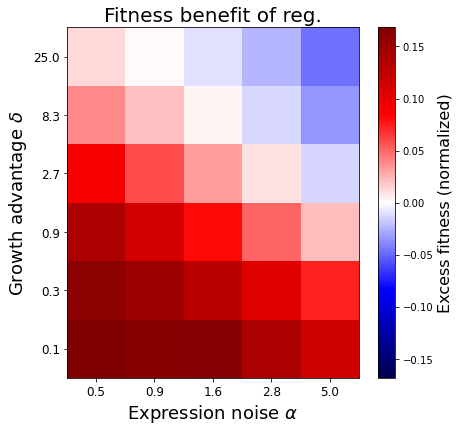

In [13]:
#Excess fitness given by regulation with precise sensing:
phase_diag = (tot_fit_reg_unsel-tot_fit_unreg_sel).T
cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
cbar.set_label(r"Excess fitness (normalized)",fontsize=16)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Fitness benefit of reg.",fontsize=20)
# fig.savefig("2a_fitness_phase_diagram.svg", format="svg")
fig.savefig("2a_fitness_phase_diagram.eps", format="eps")

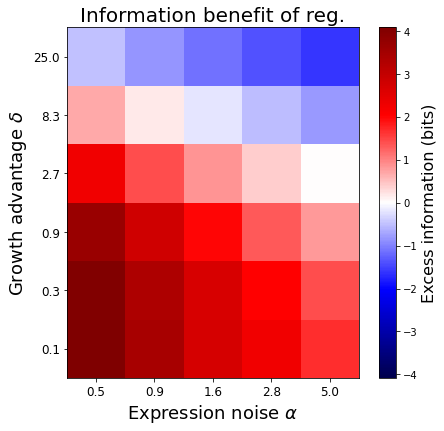

In [14]:
#Excess information given by regulation with precise sensing:
phase_diag = (MI_reg_unsel-MI_unreg_sel).T
cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
cbar.set_label(r"Excess information (bits)",fontsize=16)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Information benefit of reg.",fontsize=20)
# fig.savefig("2a_MI_phase_diagram.svg", format="svg")
fig.savefig("2a_MI_phase_diagram.eps", format="eps")

([<matplotlib.axis.YTick at 0x7f0cdc25e670>,
 [Text(0, 0, '0.1'),
  Text(0, 1, '0.3'),
  Text(0, 2, '0.9'),
  Text(0, 3, '2.7'),
  Text(0, 4, '8.3'),
  Text(0, 5, '25.0')])

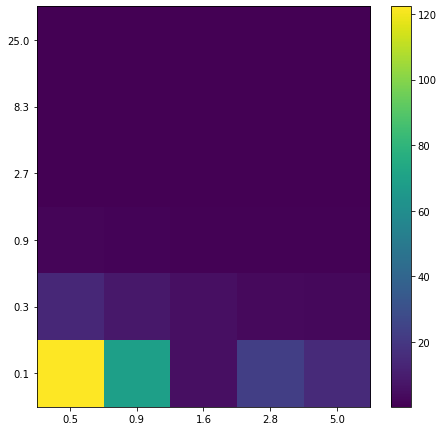

In [66]:
phase_diag = (tot_fit_unreg_sel/MI_unreg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
# pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
pic=ax.imshow(phase_diag,cmap='viridis',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))

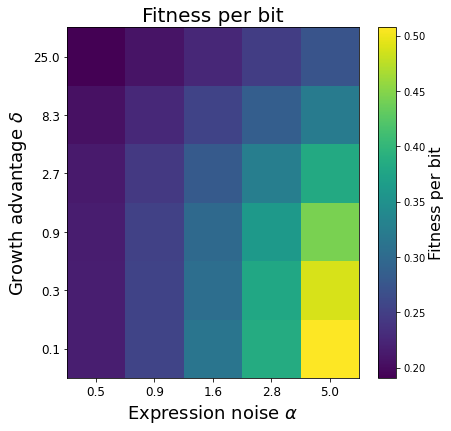

In [16]:
phase_diag = (tot_fit_reg_sel/MI_reg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,cmap='viridis',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
cbar.set_label(r"Fitness per bit",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Fitness per bit",fontsize=20)
# fig.savefig("2a_fit_per_bit_phase_diagram.svg", format="svg")
fig.savefig("2a_fit_per_bit_phase_diagram.eps", format="eps")